# Plane wave beamforming

## Define geometry (source, stations, grid)

We want to locate a source in 2 spatial dimensions (stations and source on the same plane). Note that the major difference between this notebook and `01_plane_wave_beamforming.ipynb` lies in the defintion of travel times and dimensionality of the problem.

/tmp/ipykernel_16558/3889596952.py:59: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch_1686931851744/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  ax.scatter(*slowness_space.T, s=1, fc="k", lw=0)


Text(0.5, 1.0, 'Beamforming slowness space: 180 points')

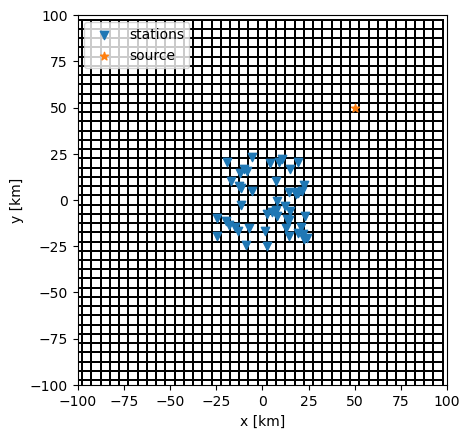

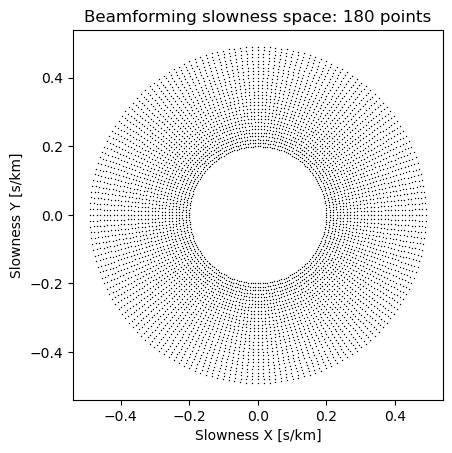

In [1]:
from itertools import product

import pylab as plt
import torch

torch.manual_seed(42)

# geometry of the problem
n_stations = 50
# uniform random distribution in [-25, 25]
stations = torch.rand((n_stations, 2)) * 50
stations -= 25
source = torch.tensor([50, 50])

# generate grid points
grid_coords = torch.arange(-100, 100, 5)
gridpoints = torch.tensor(list(product(grid_coords, repeat=2)))

# beamforming slowness grid
# defined in backazimuth [º] and abs(slowness) [s/km]
backazimuth_spacing = 2
slowness_min = 0.2
slowness_max = 0.5
slowness_spacing = 0.01

# define slowness space to beamform
# in terms of backazimuth and horizontal slowness
# Note: backazimuth is defined here as counter-clockwise from East!
azs = torch.arange(0, 2 * torch.pi, backazimuth_spacing * 2 * torch.pi / 360)
slows = torch.arange(slowness_min, slowness_max, slowness_spacing)
slowness_space = torch.stack(
    (
        torch.cos(azs[:, None]) * slows[None, :],
        torch.sin(azs[:, None]) * slows[None, :],
    ),
    dim=2,
)

# generate empty grid cells for visulation
xx, yy = torch.meshgrid(grid_coords, grid_coords, indexing="xy")
empty_cells = torch.zeros_like(xx) * torch.nan

# plotting
fig, ax = plt.subplots(1)
ax.pcolormesh(xx, yy, empty_cells, ec="k", lw=0.1)
ax.scatter(*stations.T, marker="v", label="stations")
ax.scatter(*source, marker="*", label="source")
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect("equal")
ax.legend(loc=2)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")

# plot slowness space
fig, ax = plt.subplots(1)

ax.set_aspect("equal")
ax.scatter(*slowness_space.T, s=1, fc="k", lw=0)
ax.set_xlabel("Slowness X [s/km]")
ax.set_ylabel("Slowness Y [s/km]")
ax.set_title(f"Beamforming slowness space: {slowness_space.shape[0]} points")

## Compute synthetic signals

In a field data application, replace `waveform_spectra` by your spectra of your recordings.

Text(0, 0.5, 'amplitude')

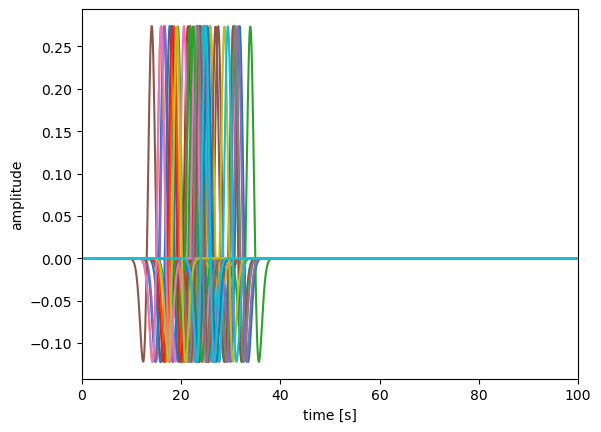

In [2]:
from scipy.signal import ricker

# define time
maxtime = 100
sampling_rate = 10
times = torch.arange(0, maxtime + 1 / sampling_rate, 1 / sampling_rate)

# compute frequencies
freqs = torch.fft.fftfreq(len(times), 1 / sampling_rate)
omega = 2 * torch.pi * freqs

# define medium
# acoustic homogeneous half-space
medium_velocity = 3

# compute travel times
distances = torch.linalg.norm(stations - source, axis=1)
traveltimes = distances / medium_velocity

# define source wavelet
wavelet = torch.fft.fft(torch.from_numpy(ricker(len(times), sampling_rate)))

# compute waveforms for all stations for given source
# Green's functions are exp(-iωt)
waveform_spectra = wavelet * torch.exp(-1j * omega[None, :] * traveltimes[:, None])
waveforms = torch.fft.fftshift(torch.fft.ifft(waveform_spectra, axis=1).real)

# plotting
fig, ax = plt.subplots(1)
ax.plot(times, waveforms.T)
ax.set_xlim(0, maxtime)
ax.set_xlabel("time [s]")
ax.set_ylabel("amplitude")


## Beamforming

In [3]:
# frequency band to beamform in
fmin, fmax = 0.1, 1.0

# compute theoretical traveltimes between all stations and all grid points
distances_to_all_gridpoints = torch.linalg.norm(
    gridpoints[:, None, :] - stations[None, :, :], axis=2
)
# dot product along last dimension (s · t)
traveltimes = slowness_space[:, :, None, :] * stations[None, None, :, :]
traveltimes = torch.sum(traveltimes, dim=3)

# limit to frequency band of interest
# translate frequency limits to indices for slicing
freq_idx = torch.where((freqs > fmin) & (freqs < fmax))[0]
# slice only selected frequencies
omega_lim = omega[freq_idx]
waveform_spectra_lim = waveform_spectra[:, freq_idx]

# Green's functions between all stations and all grid points
# within selected frequency band
greens_functions = torch.exp(
    -1j * omega_lim[None, None, None, :] * traveltimes[:, :, :, None]
)

# cross-spectral density matrix of Green's functions
S = greens_functions[:, :, :, None, :] * greens_functions.conj()[:, :, None, :, :]

# cross-spectral density matrix of recordings
K = waveform_spectra_lim[:, None, :] * waveform_spectra_lim.conj()[None, :, :]

# exclude auto-correlations, i.e., do "cross-correlation beamforming"
diag_idxs = torch.arange(K.shape[0])
zero_spectra = torch.zeros(omega_lim.shape, dtype=torch.cdouble)
K[diag_idxs, diag_idxs, :] = zero_spectra

# fix type mismatch
# 1j gives cfloat, but fft gives cdouble
S = S.type(torch.cdouble)

# this is about 2x faster than numpy einsum from my experience
beampowers = torch.einsum("srjiw, jiw -> sr", S, K).real.numpy()


Text(0, 0.5, 'slowness y [km/s]')

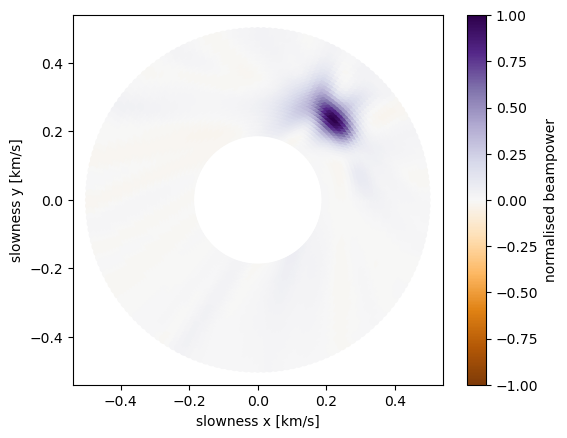

In [4]:
# plot beamforming result
fig, ax = plt.subplots(1)

# bp = beampowers.reshape(len(grid_coords), len(grid_coords))
bp = beampowers.copy()
bp /= abs(bp).max()
# pcm = ax.pcolormesh(xx, yy, bp.T, cmap="PuOr", vmin=-1, vmax=1)
pcm = ax.scatter(*slowness_space.T, c=bp.T, vmin=-1, vmax=1, cmap="PuOr")

plt.colorbar(pcm, label="normalised beampower")

ax.set_aspect("equal")
# ax.legend(loc=2)
ax.set_xlabel("slowness x [km/s]")
ax.set_ylabel("slowness y [km/s]")
